In [22]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
print(images.shape)

(2, 427, 640, 3)


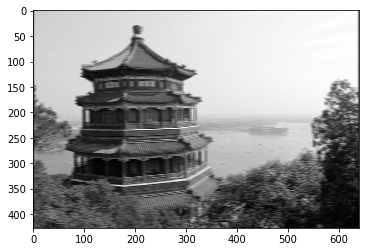

In [21]:
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0,:,:,1], cmap="gray")
plt.show()

Can also use keras to do this.

In [23]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

Max Pooling 2D, basically just sub sampling

In [24]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

Implementing ResNet using pretrained models from keras.

In [31]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

You would need to resize the images and such this would mean that you would need to call the resize function.

In [27]:
images_resized = tf.image.resize(images, [224, 224])

In [29]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
# Images need to be between 0 and 255

In [35]:
Y_proba = model.predict(inputs)
Y_proba

array([[2.0904571e-08, 6.2080893e-08, 3.4869156e-08, ..., 3.0669600e-09,
        1.3305247e-07, 8.0237427e-08],
       [5.9631873e-08, 4.5336066e-05, 2.2300461e-07, ..., 3.2232263e-05,
        2.9146429e-03, 1.0838980e-05]], dtype=float32)

In [36]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
print(top_K)

40960/35363 [==================================] - 0s 0us/step
[[('n02825657', 'bell_cote', 0.82348657), ('n03877845', 'palace', 0.067516714), ('n03781244', 'monastery', 0.041883517)], [('n03530642', 'honeycomb', 0.49828276), ('n13040303', 'stinkhorn', 0.33955023), ('n02206856', 'bee', 0.043463707)]]


If the image is not in imagenet, you can use a pretrained model and transfer learning in order to predict those images.

In [38]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /Users/jjhira/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [39]:
print(dataset)
print(info)

{'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}
tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [55]:
# test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10,15,75])
# test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
# valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
# train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

splits = ("train[:10]", "train[:15]", "train[:75]")

(train_set, valid_set, test_set), metadata = tfds.load('tf_flowers', 
                                                            split=splits, with_info=True, as_supervised=True)

In [56]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [59]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [60]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 109s 1us/step


In [64]:
for layer in base_model.layers:
    layer.trainable = False

# This can be used to freeze the weights

The below would take a long time

In [61]:
# optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = model.fit(train_set, epochs=5, validation_data=valid_set)